In [307]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [308]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [309]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    #converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    #X = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_DATE', 'PERMIT_STATUS_DATE'])

    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X

permits = loadPermits()
    
df = loadData()
df = df[columns]
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df.head()

,PERMIT_ID,UNITS,NET_UNITS,YEAR,QUARTER,NAMEADDR
1,N200505273609,1,1,2014,1,346 22nd Av
4,N200608179803,2,1,2014,1,536 40th Av
7,N200605111391,2,2,2014,1,1208 15th Av
11,N200904065665,6,6,2014,1,1701 09th Av
18,N201205180774,37,37,2014,1,25 Dolores St


In [310]:
# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))

data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data.head() 

565
567


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION
PERMIT_ID,,,,,,,,
N200201106632,3,3,2015,4,950 CORBETT AV,2004,2,47
N200207171660,8,8,2015,4,3150 GEARY BL,2005,1,44
N200212244171,81,71,2014,2,1301 Indiana St,2007,2,29
N200311240936,1,1,2015,4,652 LAKEVIEW AV,2011,3,18
N200312243005,2,2,2015,2,395 ATHENS ST,2009,3,24


In [311]:
# Split completed by 2017Q1 and still in construction by 2017Q1
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())

Completed by 2017:  384
Still in construction by 2017:  183


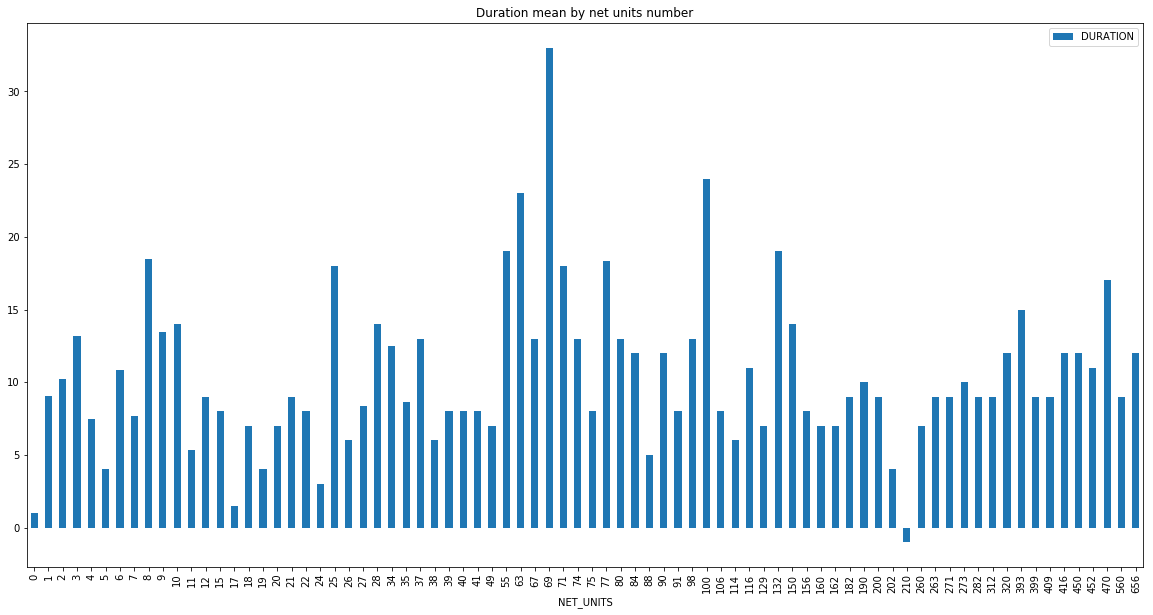

In [312]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

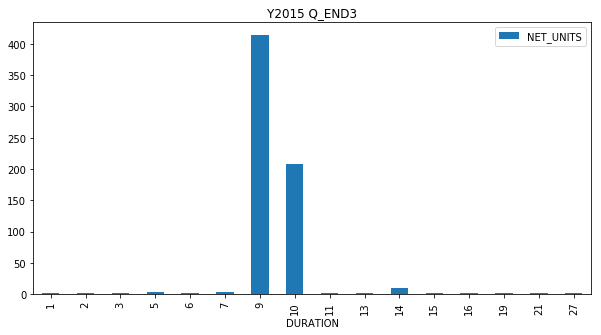

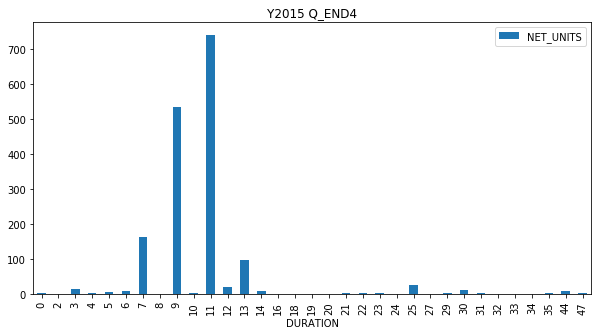

In [313]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
plot_duration(2015, 3)
plot_duration(2015, 4)

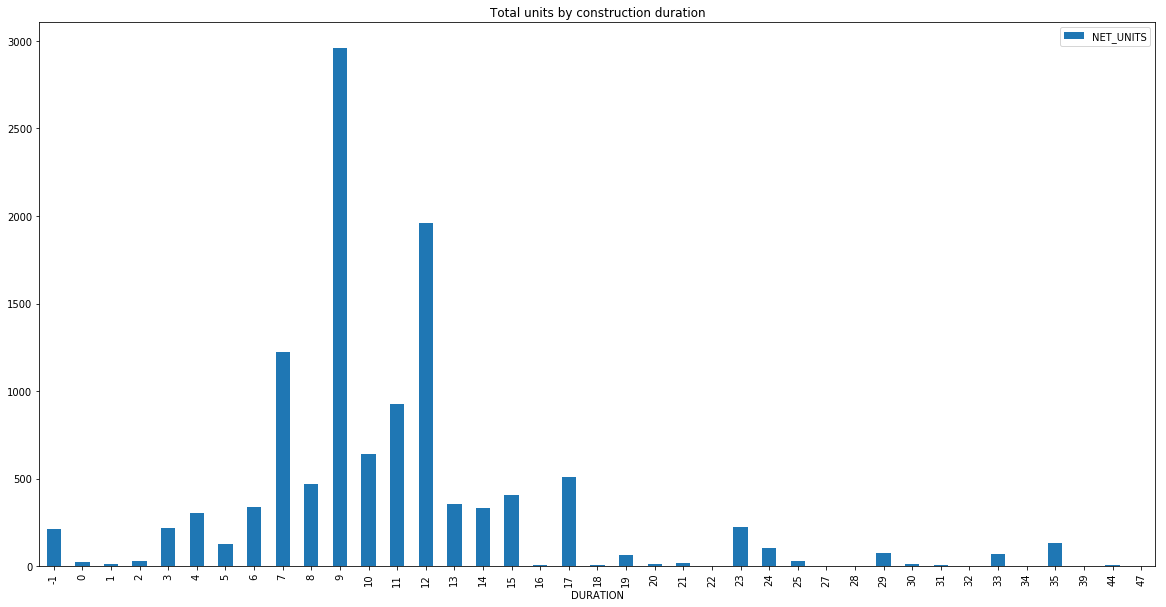

In [314]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [315]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())

result = incomplete.copy()

complete['PERMIT_DATE_YEAR'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS'] = mean_std_norm(incomplete['UNITS'])

columns_to_show = ['UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'DURATION',
                   'DURATION_PREDICTED', 'NAMEADDR']

In [321]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 
        
def train(model):
    return model.fit(X_train[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']], y_train)

def validate(model):
    print("Validation on historical data:")
    y_val_predicted = model.predict(X_val[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']])
    X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)

    # prediction error
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
    display(X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15))
    
def predict_with_model(model):
    print("Prediction for not completed buildings:")
    duration_predicted = model.predict(incomplete[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']])
    result['DURATION_PREDICTED'] = np.ceil(duration_predicted)
    result['QUARTERS_LEFT'] = result['DURATION_PREDICTED'] - result['DURATION']

    prediction = result[columns_to_show + ['QUARTERS_LEFT']].sort_values(by=['NET_UNITS'],ascending=False)
    prediction.to_csv("data_complete/predictions.csv")
    
    grouped = prediction.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units delivered by quarters left")
    
    display(prediction.head(30))

In [322]:
# with random forest

model = train(RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6))
print('Feature importances: \n', model.feature_importances_)
validate(model)

Feature importances: 
 [ 0.04723789  0.9318528   0.02090932]
Validation on historical data:
Mean squared error: 9.39


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR
PERMIT_ID,,,,,,
N200605161774,4.508344,452,-0.018495,11,11.0,399 FREMONT ST
N201009140800,3.082907,320,-0.491977,12,11.0,45 LANSING ST
N201312184508,2.434981,260,0.454986,7,9.0,1634 - 1690 PINE ST
N201106017202,1.592677,182,-0.491977,7,11.0,260 05th St
N201307051190,1.376702,162,0.454986,7,9.0,101 POLK ST
N200810315586,1.311910,156,-0.018495,8,11.0,1415 MISSION ST
N201312265046,1.020343,129,0.928467,7,5.0,360 BERRY ST
N201311222660,0.458807,77,0.454986,9,10.0,2101 & 2155 WEBSTER ST
N201105166063,0.437209,75,-0.491977,9,11.0,235 Broadway


Prediction for not completed buildings:


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR,QUARTERS_LEFT
PERMIT_ID,,,,,,,
N201603172392,1600,994,2016,2,7.0,HOPE SF POTRERO (BP ISSUED),5.0
N201309045886,557,557,2014,11,12.0,801 BRANNAN ST,1.0
N201209069080,550,550,2013,14,13.0,TRINITY PLAZA,-1.0
N201406138394,431,431,2016,4,9.0,150 VAN NESS AV,5.0
N201404304554,418,418,2015,7,11.0,41 TEHAMA ST,4.0
N201406259383,326,326,2015,6,9.0,800 INDIANA ST,3.0
N201312234917,300,300,2015,8,11.0,1201 - 1225 TENNESSEE ST,3.0
N201408133775,198,198,2015,7,11.0,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,4.0
N201408133766,152,152,2015,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,3.0


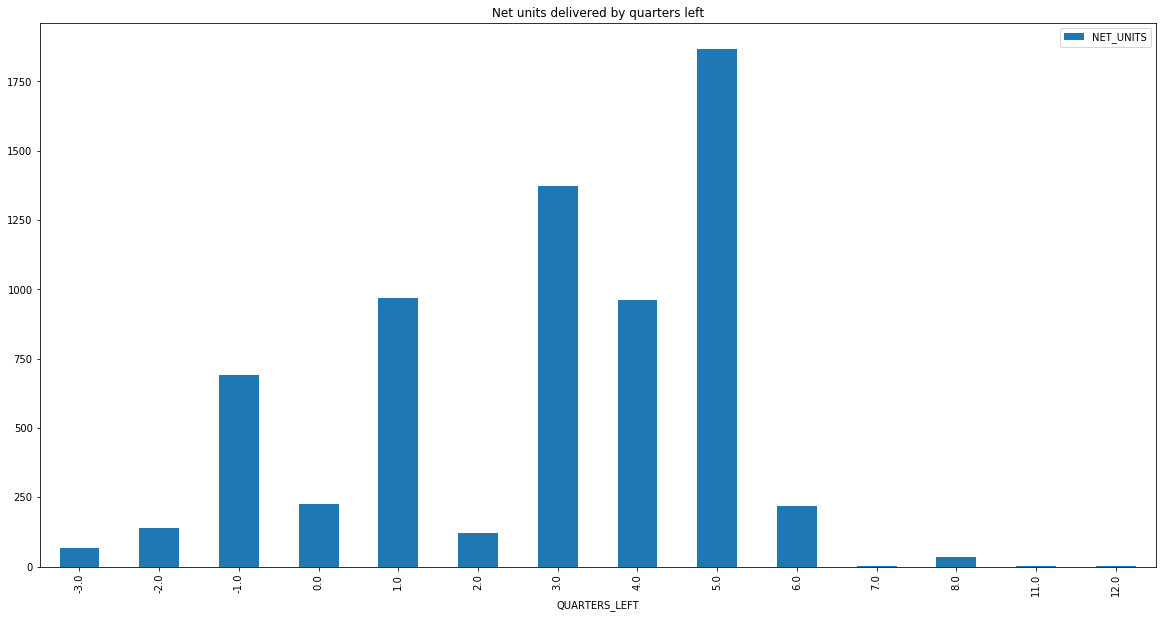

In [323]:
predict_with_model(model)

In [324]:
# with linear regression

model = train(linear_model.LinearRegression(fit_intercept=True, normalize=False))
print('Coefficients: \n', model.coef_)
validate(model)

Coefficients: 
 [-0.01565733 -7.36597547 -0.95543223]
Validation on historical data:
Mean squared error: 10.76


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR
PERMIT_ID,,,,,,
N200605161774,4.508344,452,-0.018495,11,11.0,399 FREMONT ST
N201009140800,3.082907,320,-0.491977,12,14.0,45 LANSING ST
N201312184508,2.434981,260,0.454986,7,6.0,1634 - 1690 PINE ST
N201106017202,1.592677,182,-0.491977,7,14.0,260 05th St
N201307051190,1.376702,162,0.454986,7,8.0,101 POLK ST
N200810315586,1.311910,156,-0.018495,8,10.0,1415 MISSION ST
N201312265046,1.020343,129,0.928467,7,5.0,360 BERRY ST
N201311222660,0.458807,77,0.454986,9,6.0,2101 & 2155 WEBSTER ST
N201105166063,0.437209,75,-0.491977,9,14.0,235 Broadway


Prediction for not completed buildings:


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR,QUARTERS_LEFT
PERMIT_ID,,,,,,,
N201603172392,1600,994,2016,2,4.0,HOPE SF POTRERO (BP ISSUED),2.0
N201309045886,557,557,2014,11,14.0,801 BRANNAN ST,3.0
N201209069080,550,550,2013,14,18.0,TRINITY PLAZA,4.0
N201406138394,431,431,2016,4,6.0,150 VAN NESS AV,2.0
N201404304554,418,418,2015,7,10.0,41 TEHAMA ST,3.0
N201406259383,326,326,2015,6,9.0,800 INDIANA ST,3.0
N201312234917,300,300,2015,8,11.0,1201 - 1225 TENNESSEE ST,3.0
N201408133775,198,198,2015,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,3.0
N201408133766,152,152,2015,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,3.0


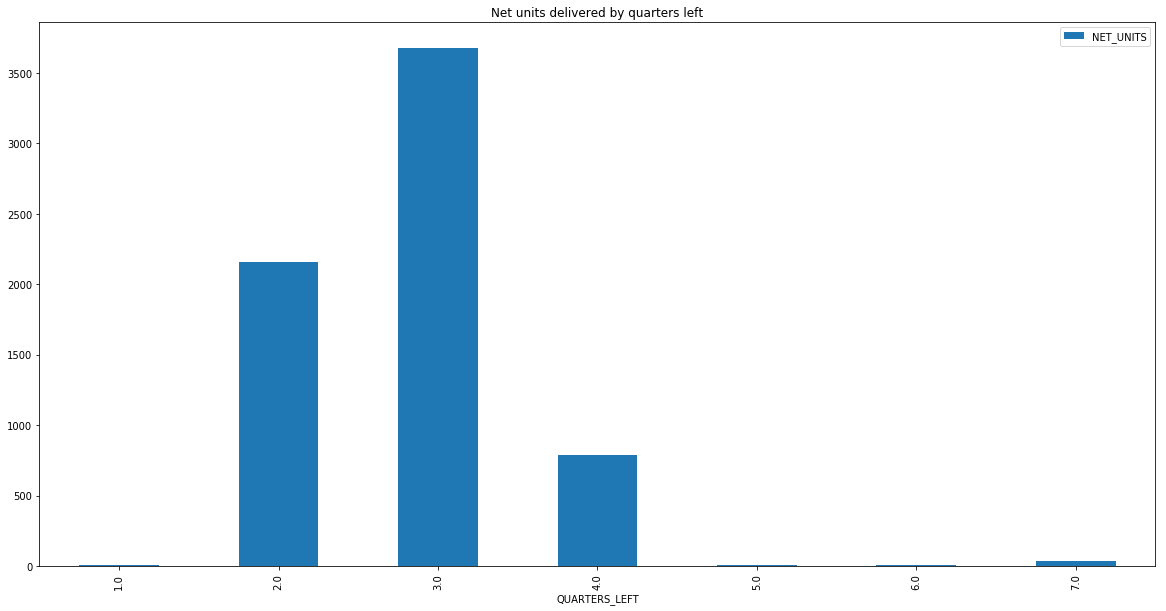

In [325]:
predict_with_model(model)